In [1]:
import rosbag_pandas
import pandas as pd
import numpy as np

width = 12
height = 0.382 / 0.618 * width
fontsize = 12

file = '2020-07-24-21-12-47.bag'
# Open file
df = rosbag_pandas.bag_to_dataframe(file)

In [2]:
df_temp = pd.to_datetime(df['/moa/adis16448bmlz/imu/temp/header/stamp/secs'], unit='s') + pd.to_timedelta(df['/moa/adis16448bmlz/imu/temp/header/stamp/nsecs'], unit='ns')
df_temp = df_temp.reset_index()
df_temp.columns = ['t_arrival', 't']
df_temp.insert(2, 'temperature [C]', df['/moa/adis16448bmlz/imu/temp/temperature'].values, True)
df_temp.dropna(inplace=True)
df_temp = df_temp.drop('t_arrival', axis=1)
df_temp = df_temp.set_index('t')

df_filter = pd.to_datetime(df['/moa/time_sync/remote_time/secs'], unit='s') + pd.to_timedelta(df['/moa/time_sync/remote_time/nsecs'], unit='ns')
df_filter = df_filter.reset_index()
df_filter.columns = ['t_arrival', 't']
df_filter.insert(2, 'tau [us] (left)', df['/moa/time_sync/x/0'].values, True)
df_filter.insert(3, 'V0 [V] (right)', df['/moa/time_sync/x/1'].values, True)
df_filter.insert(4, 'c [ppm/V] (left)', df['/moa/time_sync/x/2'].values, True)
df_filter.insert(5, 'sigma tau [us]', np.sqrt(df['/moa/time_sync/P/0']).values, True)
df_filter.insert(6, 'sigma V0 [V]', np.sqrt(df['/moa/time_sync/P/4']).values, True)
df_filter.insert(7, 'sigma c [ppm/V]', np.sqrt(df['/moa/time_sync/P/8']).values, True)
df_filter.insert(8, 'V_DAC [V] (right)', 3.3 / 1023.0 * df['/moa/time_sync/dac'].values, True)
df_filter.dropna(inplace=True)
df_filter.drop('t_arrival', axis=1, inplace=True)
df_filter.set_index('t', inplace=True)

df_all = df_filter.join(df_temp)
df_all.interpolate(inplace=True)
df_all.dropna(inplace=True)
#df_all.drop(pd.Timestamp('1970-01-01 00:00:00'), inplace=True)

<Figure size 432x288 with 0 Axes>

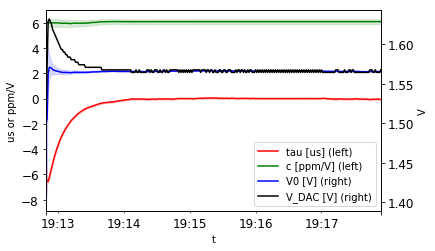

In [10]:
import matplotlib.pyplot as plt
plt.close('all')
plt.figure()
width = 6
height = 0.382 / 0.618 * width
fontsize = 12
#%matplotlib qt
ax1 = df_all[['tau [us] (left)', 'c [ppm/V] (left)', 'V0 [V] (right)', 'V_DAC [V] (right)']].plot(figsize=(width,height), color='rgbk', fontsize=fontsize, secondary_y=['V0 [V] (right)', 'V_DAC [V] (right)'], mark_right=False)
ax1.fill_between(df_all.index.values, (df_all['tau [us] (left)']-2*df_all['sigma tau [us]']).values, (df_all['tau [us] (left)']+2*df_all['sigma tau [us]']).values, color='r', alpha=.15)
ax1.fill_between(df_all.index.values, (df_all['c [ppm/V] (left)']-2*df_all['sigma c [ppm/V]']).values, (df_all['c [ppm/V] (left)']+2*df_all['sigma c [ppm/V]']).values, color='g', alpha=.15)
ax1.right_ax.fill_between(df_all.index.values, (df_all['V0 [V] (right)']-2*df_all['sigma V0 [V]']).values, (df_all['V0 [V] (right)']+2*df_all['sigma V0 [V]']).values, color='bk', alpha=.15)

ax1.set_ylabel('us or ppm/V')
ax1.right_ax.set_ylabel('V')
ax1.get_figure().savefig("plots/timeseries.pdf", bbox_inches='tight')